In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
from sklearn import datasets
from time import time
import sys
import random

In [11]:
n_samples = 10000
n_features = 20
X_numpy, Y_numpy = datasets.make_regression(n_samples=n_samples, n_features=n_features, noise=20, random_state=4)
X = torch.from_numpy(X_numpy.astype(np.float32))
Y = torch.from_numpy(Y_numpy.astype(np.float32)).view(-1, 1)

In [12]:
def gradient_descent(x, y, model, loss, lr, n_iters):
    total_loss = np.zeros(n_iters)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for k in range(n_iters):
        y_pred = model(x)
        l = loss(y_pred, y)
        l.backward()
        total_loss[k] = l.item()
        optimizer.step()
        optimizer.zero_grad()
    return total_loss

In [19]:
def spider_boost(x, y, model, loss, lr, full_grad_count, n_iters, samples_num):
    total_loss = np.zeros(n_iters)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    q = n_iters // full_grad_count
    mask_helper = range(y.shape[0])

    sample = None
    extra_grads = None
    
    for k in range(n_iters):
        y_pred = model(x)
        if k % q == 0:
            #print('full grad')
            # Compute sample and gradients sum for the next step
            optimizer.zero_grad()
            sample = random.sample(mask_helper, samples_num)
            extra_loss = loss(y_pred[sample], y[sample])
            extra_loss.backward(retain_graph=True)
            extra_grads = [p.grad.clone().detach() for p in model.parameters()]
            
            #print(f'iter={k}: saving extra_grads')
            #for gr in extra_grads:
            #    print(f'extra grad = {gr}')
            
            # Optimize with usual default gradient descent
            optimizer.zero_grad()
            main_loss = loss(y_pred, y)
            main_loss.backward()
            total_loss[k] = main_loss.item()
            optimizer.step()
        else:
            #print('sum grads')
            # Add precomputed negative gradients
            with torch.no_grad():
                #print(f'iter={k}, substracting extra_grads')
                for p, ex_grad in zip(model.parameters(), extra_grads):
                    #print(f'curr grad = {p.grad}, extra grad = {ex_grad}')
                    """
                    HERE IT SHOULD BE SUBSTRACTION INSTEAD OF ADDITION
                    """
                    p.grad.add_(ex_grad)
            
            #for p in model.parameters():
            #    print(f'grad after substracting = {p.grad}')
            
            # Add current step gradients, using precomputed sample
            positive_loss = loss(y_pred[sample], y[sample])
            positive_loss.backward(retain_graph=True)
            
            #for p in model.parameters():
            #    print(f'grad after adding = {p.grad}')
            
            sample = None
            extra_grads = None
            
            # Compute sample and negative gradients sum for the next step
            if (k + 1) % q != 0:
                # Save current gradients
                curr_grads = [p.grad.clone().detach() for p in model.parameters()]
                #print(f'saving curr_grads: {curr_grads}')
                
                # Compute sample and gradients sum for the next step
                optimizer.zero_grad()
                sample = random.sample(mask_helper, samples_num)
                extra_loss = loss(y_pred[sample], y[sample])
                extra_loss.backward()
                extra_grads = [p.grad.clone().detach() for p in model.parameters()]
                
                #print(f'iter={k}: saving extra_grads')
                #for gr in extra_grads:
                #    print(f'extra grad = {gr}')
                
                # Return gradients back
                optimizer.zero_grad()
                with torch.no_grad():
                    for p, curr_grad in zip(model.parameters(), curr_grads):
                        p.grad = curr_grad
                        #print(f'curr_grad is again {p.grad}')
            
            # Save total loss
            main_loss = loss(y_pred, y)
            total_loss[k] = main_loss.item()
            
            # Optimize with sum of three components
            optimizer.step()
    return total_loss

In [20]:
learning_rate = 0.01
n_iters = 50
full_grad_count = n_iters // 10
samples_num = n_samples // 2
loss = torch.nn.nn.NLLLoss()

AttributeError: module 'torch.nn' has no attribute 'nn'

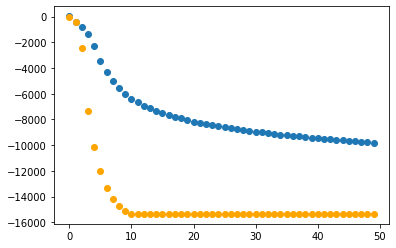

In [21]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred
    
model = LogisticRegression(n_features, 1)
gd_total_loss = gradient_descent(X, Y, model, loss, learning_rate, n_iters)

model = LogisticRegression(n_features, 1)
sp_boost_total_loss = spider_boost(X, Y, model, loss, learning_rate, full_grad_count, n_iters, samples_num)

plt.scatter(np.arange(n_iters), gd_total_loss)
plt.scatter(np.arange(n_iters), sp_boost_total_loss, color='orange')